In [1]:
# Standard python modules
from functools import lru_cache
from os.path import expanduser, join

# Extra python modules
from bert_serving.client import BertClient
from bpemb import BPEmb
from IPython.display import display
#from gensim.models.fasttext import FastText
import numpy as np
from numpy.linalg import norm
#import pandas as pd
import requests

import json
import csv
import itertools
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# INSTALL
#pip install bert-serving-server  # server
#pip install bert-serving-client  # client, independent of `bert-serving-server`

In [2]:
# The data we will work on is from the `dasem` toolbox available at https://github.com/fnielsen/dasem
# Only the four_words_2.csv file is necessary here, - not the rest of `dasem`.
#filename_four_words = expanduser(r'/home/s165541/Bert/four_words_english.csv')
#four_words = pd.read_csv(filename_four_words)

wordToSimilarWordsMap = {}
with open(r'C:/Users/thina/Documents/Matematik_og_teknologi/Advanced Machine Learning/FastText/Finn_data_dansk.json', "r", encoding = 'utf8') as read_file:
    data = json.load(read_file)
    for wordObj in data:
        wordToSimilarWordsMap[wordObj['word']] = wordObj['lexeme']

four_words_txt = []
with open(r'C:/Users/thina/Documents/Matematik_og_teknologi/Advanced Machine Learning/FastText/Finn_data_dansk.txt', newline='', encoding = 'utf8') as file:
    data = file.read().strip()
lines = data.split("\n")
four_words_txt = [line.split(",") for line in lines]
four_words_txt = [[element.strip() for element in row] for row in four_words_txt]

four_words_txt.pop(0)
# The fasttext model is available from https://fasttext.cc/docs/en/crawl-vectors.html
#filename_fasttext_model = expanduser(join('~', 'data', 'fasttext', 'cc.da.300.bin'))

# multi_cased_L-12_H-768_A-12 may be be downloaded from
# https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
#https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip

#import zipfile
#with zipfile.ZipFile('/home/s165541/Bert/multi_cased_L-12_H-768_A-12.zip', 'r') as zip_ref:
#    zip_ref.extractall('/home/s165541/Bert')


# BPEmb are downloaded automatically

['word1', 'word2', 'word3', 'word4']

In [4]:
# Run in terminal 
# python start-bert-as-service.py -model_dir ./multi_cased_L-12_H-768_A-12 -num_worker=1

In [3]:
bc = BertClient(ip='localhost')

In [4]:
print(bc.encode(wordToSimilarWordsMap['tog']).shape)
print(four_words_txt[82])
print(wordToSimilarWordsMap[four_words_txt[82][1]])
print(four_words_txt[85][1].split())
print(wordToSimilarWordsMap[four_words_txt[85][0]])

(10, 768)
['hans', 'sit', 'vores', 'vises']
['sit', 'sine', 'sin']
['personer']
['mændene', 'manden', 'mand', 'mænd']


## One word 

In [38]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers = [], [], [], [], [], []
for i in range(len(four_words_txt)): 
    vectors = np.zeros((4,768))
    for j in range(4): 
        word = four_words_txt[i][j]
        #if len(word.split()) is 1: 
        vectors[j,:] = bc.encode([word])
        #elif len(word.split()) is 2: 
        #    word = word.split()
        #    vectors[j,:] = np.mean(bc.encode(wordToSimilarWordsMap[word[0]])+bc.encode(wordToSimilarWordsMap[word[1]]), axis=0)
        #elif len(word.split()) is 3:
        #    word = word.split()
        #    vectors[j,:] = np.mean(bc.encode(wordToSimilarWordsMap[word[0]])+bc.encode(wordToSimilarWordsMap[word[1]])+bc.encode(wordToSimilarWordsMap[word[2]]), axis=0)
        
        
    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    
    
    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector

    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)
    

Progress 0
Progress 10
Progress 20
Progress 30
Progress 40
Progress 50
Progress 60
Progress 70
Progress 80
Progress 90


In [40]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.56
Outlier detection using covarians 0.42
Outlier detection using dot 0.42
Outlier detection using SVD 0.38
Outlier detection using PCA 0.38
Outlier detection using cosine 0.56


In [7]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame({'Word 1': np.array(four_words_txt)[:,0], 'Word 2': np.array(four_words_txt)[:,1], 'Word 3': np.array(four_words_txt)[:,2], 'Word 4': np.array(four_words_txt)[:,3], 'corrcoef': corrcoef_outliers, 
            'cov':cov_outliers, 'dot':dot_outliers,'SVD':svd_outliers, 'PCA':pca_outliers , 'cosine': cosine_outliers})

,Word 1,Word 2,Word 3,Word 4,corrcoef,cov,dot,SVD,PCA,cosine
0,æble,pære,kirsebær,stol,stol,stol,stol,stol,stol,stol
1,stol,bord,reol,græs,græs,stol,stol,græs,græs,græs
2,græs,træ,blomst,bil,bil,bil,bil,blomst,græs,bil
3,bil,cykel,tog,vind,bil,bil,bil,tog,tog,bil
4,vind,regn,solskin,mandag,mandag,mandag,mandag,solskin,solskin,mandag
5,mandag,tirsdag,søndag,tømrer,tømrer,mandag,mandag,tømrer,tømrer,tømrer
6,tømrer,vvs-mand,snedker,barn,vvs-mand,barn,barn,barn,barn,vvs-mand
7,barn,far,mormor,lampe,lampe,lampe,lampe,far,far,lampe
8,lampe,stearinlys,lommelygte,jern,lommelygte,jern,jern,lommelygte,lommelygte,lommelygte
9,jern,guld,magnesium,sjov,guld,sjov,sjov,guld,guld,guld


# Knowledge Graph

In [8]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers = [], [], [], [], [], []
for i in range(len(four_words_txt)): 
    vectors = np.zeros((4,768))
    for j in range(4): 
        word = four_words_txt[i][j]
        vectors[j,:] = np.mean(bc.encode(wordToSimilarWordsMap[word]), axis = 0)

    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    
    
    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector

    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)

Progress 0
Progress 10
Progress 20
Progress 30
Progress 40
Progress 50
Progress 60
Progress 70
Progress 80
Progress 90


In [11]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.58
Outlier detection using covarians 0.36
Outlier detection using dot 0.36
Outlier detection using SVD 0.35
Outlier detection using PCA 0.39
Outlier detection using cosine 0.58


In [12]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame({'Word 1': np.array(four_words_txt)[:,0], 'Word 2': np.array(four_words_txt)[:,1], 'Word 3': np.array(four_words_txt)[:,2], 'Word 4': np.array(four_words_txt)[:,3], 'corrcoef': corrcoef_outliers, 
            'cov':cov_outliers, 'dot':dot_outliers,'SVD':svd_outliers, 'PCA':pca_outliers , 'cosine': cosine_outliers})

,Word 1,Word 2,Word 3,Word 4,corrcoef,cov,dot,SVD,PCA,cosine
0,æble,pære,kirsebær,stol,stol,æble,æble,stol,stol,stol
1,stol,bord,reol,græs,græs,stol,stol,reol,græs,græs
2,græs,træ,blomst,bil,bil,bil,bil,blomst,blomst,bil
3,bil,cykel,tog,vind,bil,bil,bil,vind,vind,bil
4,vind,regn,solskin,mandag,solskin,vind,vind,regn,mandag,solskin
5,mandag,tirsdag,søndag,tømrer,tømrer,søndag,søndag,tømrer,tømrer,tømrer
6,tømrer,vvs-mand,snedker,barn,vvs-mand,barn,barn,barn,barn,vvs-mand
7,barn,far,mormor,lampe,lampe,barn,barn,mormor,lampe,lampe
8,lampe,stearinlys,lommelygte,jern,lommelygte,lampe,lampe,jern,lommelygte,lommelygte
9,jern,guld,magnesium,sjov,guld,guld,guld,magnesium,magnesium,guld


## Four words

In [9]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers = [], [], [], [], [], []
for i in range(len(four_words_txt)): 

    vectors = bc.encode(four_words_txt[i])
        
    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    
    
    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector

    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)

Progress 0
Progress 10
Progress 20
Progress 30
Progress 40
Progress 50
Progress 60
Progress 70
Progress 80
Progress 90


In [10]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.56
Outlier detection using covarians 0.42
Outlier detection using dot 0.42
Outlier detection using SVD 0.38
Outlier detection using PCA 0.37
Outlier detection using cosine 0.56


In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame({'Word 1': np.array(four_words_txt)[:,0], 'Word 2': np.array(four_words_txt)[:,1], 'Word 3': np.array(four_words_txt)[:,2], 'Word 4': np.array(four_words_txt)[:,3], 'corrcoef': corrcoef_outliers, 
            'cov':cov_outliers, 'dot':dot_outliers,'SVD':svd_outliers, 'PCA':pca_outliers , 'cosine': cosine_outliers})

,Word 1,Word 2,Word 3,Word 4,corrcoef,cov,dot,SVD,PCA,cosine
0,æble,pære,kirsebær,stol,stol,stol,stol,stol,stol,stol
1,stol,bord,reol,græs,græs,stol,stol,græs,græs,græs
2,græs,træ,blomst,bil,bil,bil,bil,blomst,græs,bil
3,bil,cykel,tog,vind,bil,bil,bil,tog,tog,bil
4,vind,regn,solskin,mandag,mandag,mandag,mandag,solskin,solskin,mandag
5,mandag,tirsdag,søndag,tømrer,tømrer,mandag,mandag,tømrer,tømrer,tømrer
6,tømrer,vvs-mand,snedker,barn,vvs-mand,barn,barn,barn,barn,vvs-mand
7,barn,far,mormor,lampe,lampe,lampe,lampe,far,far,lampe
8,lampe,stearinlys,lommelygte,jern,lommelygte,jern,jern,lommelygte,lommelygte,lommelygte
9,jern,guld,magnesium,sjov,guld,sjov,sjov,guld,guld,guld


## Using word similarity sentences

In [21]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers, cosine_matrix, X_pca = [], [], [], [], [], [], [], []
dist_pca, pca_vectors = [], []
for i in range(len(four_words_txt)): 
    vectors = np.zeros((4,768))
    word0 = four_words_txt[i][0]
    word1 = four_words_txt[i][1]
    word2 = four_words_txt[i][2]
    word3 = four_words_txt[i][3]
        

    vectors[0,:] = bc.encode(['Hvor stor er ligheden mellem '+word0+' og '+word1+' , '+word2+' , '+word3])
    vectors[1,:] = bc.encode(['Hvor stor er ligheden mellem '+word1+' og '+word0+' , '+word2+' , '+word3])
    vectors[2,:] = bc.encode(['Hvor stor er ligheden mellem '+word2+' og '+word0+' , '+word1+' , '+word3])
    vectors[3,:] = bc.encode(['Hvor stor er ligheden mellem '+word3+' og '+word0+' , '+word1+' , '+word2])
    
        
    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    cosine_matrix.append(cosine)
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    

    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs.T,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    pca_vectors.append(pca_vecs)
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector
    X_pca.append(X_pca_vecs)
    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    dist_pca.append(Dist_pca_vecs)
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)

Progress 0
Progress 10
Progress 20
Progress 30
Progress 40
Progress 50
Progress 60
Progress 70
Progress 80
Progress 90


In [6]:
def plot_cosine_heatmap(cosine_mat, words):
     
    fig, ax = plt.subplots()
    im = ax.imshow(cosine_mat)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(words)))
    ax.set_yticks(np.arange(len(words)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(words)
    ax.set_yticklabels(words)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(words)):
        for j in range(len(words)):
            text = ax.text(j, i, round(cosine_mat[i, j],2),
                           ha="center", va="center", color="w")

    ax.set_title("Cosine similarity")
    fig.tight_layout()
    plt.show()


100 100


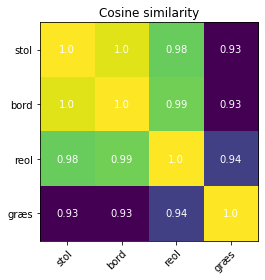

In [7]:
N = 1
print(len(cosine_matrix), len(four_words_txt))
plot_cosine_heatmap(cosine_matrix[N], four_words_txt[N])

In [23]:
def scatter_plot(X_pca, W, N, pred, Dist, figname, pca_vecs): 
    X_transformed = X_pca 
    title = "PCA"
    fig = plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    for i in range(4):
        print(X_transformed[i][0], W[N][i])
        plt.text(X_transformed[i][0], X_transformed[i][1], "%s" %(W[N][i]), color = 'black', size=18)
        plt.scatter(X_transformed[i][0], X_transformed[i][1], color='deepskyblue', lw=5, label="%s = %.3f" %(W[N][i],Dist[i]))
        
    plt.scatter(X_transformed[-1][0], X_transformed[-1][1],color='red', lw=2, label='center')   
    plt.title('PCA sentence2 [%s, %s, %s, %s] = %s' %(W[N][0],W[N][1],W[N][2],W[N][3],pred), size=20)
    plt.legend(prop={'size': 15},loc=1)
    plt.xlabel('Principal Component 1', size=15)
    plt.ylabel('Principal Component 2', size=15)
    
    
    plt.subplot(1,2,2)
    cumsum_var = np.cumsum(pca_vecs.explained_variance_ratio_) 
    Comp = 2
    plt.plot(cumsum_var[:2])
    plt.scatter(0,cumsum_var[0])
    plt.text(0,cumsum_var[0], '(%d,%.5f)' %(0,cumsum_var[0]), size=18)
    plt.scatter(1,cumsum_var[1])
    plt.text(1,cumsum_var[1], '(%d,%.2f)' %(1,cumsum_var[1]), size=18)
    plt.xlabel('number of components', size=15)
    plt.ylabel('cumulative explained variance', size=15)
    plt.axis([0, 1.1, 0, 1.1])
    
    
    plt.show()    
    #plt.savefig(figname)

-0.45586685326345544 æble
-0.4966537132857422 pære
-0.5786416553345507 kirsebær
1.5311622218837482 stol


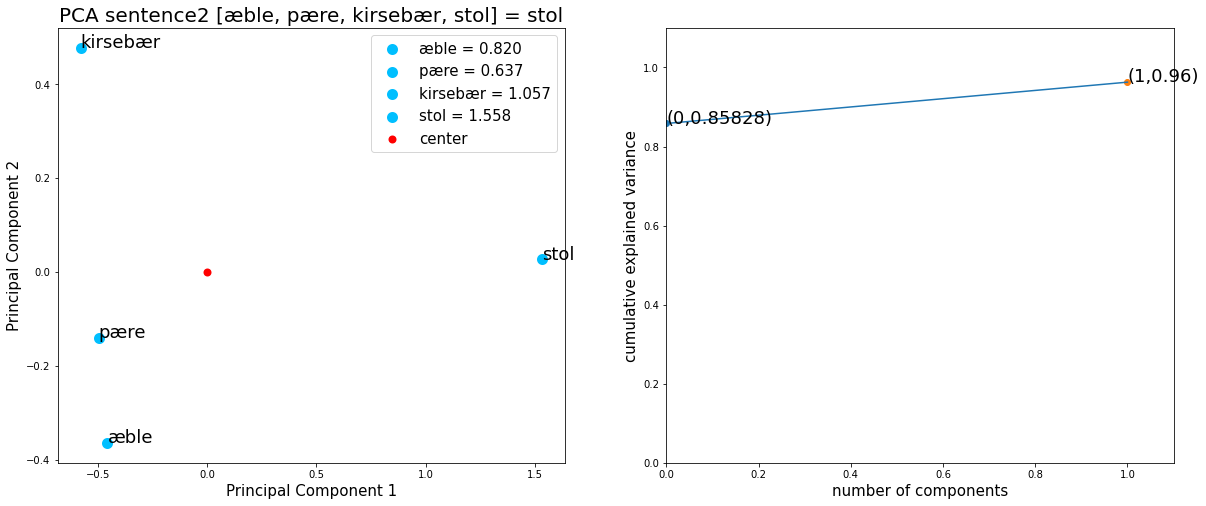

In [24]:
N = 0 # 45, 56, 75, 
W = four_words_txt
X_pca_test = X_pca[N] 
dist = dist_pca[N]
pred = pca_outliers[N]
pca_vecs = pca_vectors[N]
figurename = 'scatter_plot_bert_s2.png'
scatter_plot(X_pca_test, W, N, pred, dist, figurename, pca_vecs)

In [37]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.99
Outlier detection using covarians 0.4
Outlier detection using dot 0.4
Outlier detection using SVD 0.35
Outlier detection using PCA 0.97
Outlier detection using cosine 0.99


In [84]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame({'Word 1': np.array(four_words_txt)[:,0], 'Word 2': np.array(four_words_txt)[:,1], 'Word 3': np.array(four_words_txt)[:,2], 'Word 4': np.array(four_words_txt)[:,3], 'corrcoef': corrcoef_outliers, 
            'cov':cov_outliers, 'dot':dot_outliers,'SVD':svd_outliers, 'PCA':pca_outliers , 'cosine': cosine_outliers})

,Word 1,Word 2,Word 3,Word 4,corrcoef,cov,dot,SVD,PCA,cosine
0,æble,pære,kirsebær,stol,stol,stol,stol,stol,stol,stol
1,stol,bord,reol,græs,græs,reol,reol,græs,græs,græs
2,græs,træ,blomst,bil,bil,træ,træ,bil,bil,bil
3,bil,cykel,tog,vind,vind,tog,tog,vind,vind,vind
4,vind,regn,solskin,mandag,mandag,mandag,mandag,mandag,mandag,mandag
5,mandag,tirsdag,søndag,tømrer,tømrer,søndag,søndag,tømrer,tømrer,tømrer
6,tømrer,vvs-mand,snedker,barn,barn,vvs-mand,vvs-mand,barn,barn,barn
7,barn,far,mormor,lampe,lampe,far,far,lampe,lampe,lampe
8,lampe,stearinlys,lommelygte,jern,jern,jern,jern,jern,jern,jern
9,jern,guld,magnesium,sjov,sjov,sjov,sjov,sjov,sjov,sjov


In [12]:
print('The four words',four_words_txt[56],'and the wrong prediction is [' ,cosine_outliers[56], ']')

The four words ['mener', 'tror', 'ved', 'går'] and the wrong prediction is [ ved ]


In [121]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers = [], [], [], [], [], []
for i in range(len(four_words_txt)): 
    vectors = np.zeros((4,768))
    word0 = four_words_txt[i][0]
    word1 = four_words_txt[i][1]
    word2 = four_words_txt[i][2]
    word3 = four_words_txt[i][3]
    
    vectors[0,:] = bc.encode(['Er '+word0+' i samme kategori som '+word1+' , '+word2+' og '+word3])
    vectors[1,:] = bc.encode(['Er '+word1+' i samme kategori som '+word0+' , '+word2+' og '+word3])
    vectors[2,:] = bc.encode(['Er '+word2+' i samme kategori som '+word0+' , '+word1+' og '+word3])
    vectors[3,:] = bc.encode(['Er '+word3+' i samme kategori som '+word0+' , '+word1+' og '+word2])
        
    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    
    
    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector

    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)

æble
Progress 0
stol
græs
bil
vind
mandag
tømrer
barn
lampe
jern
sjov
Progress 10
papir
vagt
by
småkage
dør
klaver
fandens
vand
hukommelse
Niels Bohr
Progress 20
Lars Løkke Rasmussen
Peter Schmeichel
Caroline Wozniacki
Monaco
Pia
bold
mave
hat
ishockey
gå
Progress 30
rød
Finland
Kina
humor
vaskemaskine
restaurant
øl
køkken
wing
vinge
Progress 40
kartoffel
Viborg
Kattegat
eg
hugorm
ko
ugle
hund
spilletid
tv
Progress 50
ondt
hoppende
saver
går
gange
mener
fire
Nielsen
mega
kufferter
Progress 60
landstræner
trup
grafik
januar
angiveligt
oplysninger
fire minutter
instrumentbrættet
anmeldelse
instrueret
Progress 70
billede
kapitel
virksomhed
tres
1864
diplom
bange
norsk
mus
dør
Progress 80
og
hans
stod og råbte
frokost
mænd
kidnappe
råbte
kontorist
vegetation
cyklist
Progress 90
bibliotek
halvsyg
musik
rapport
tekande
forhører
fremtidige
kanal
kanal


In [97]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.92
Outlier detection using covarians 0.74
Outlier detection using dot 0.74
Outlier detection using SVD 0.31
Outlier detection using PCA 0.86
Outlier detection using cosine 0.92


In [11]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame({'Word 1': np.array(four_words_txt)[:,0], 'Word 2': np.array(four_words_txt)[:,1], 'Word 3': np.array(four_words_txt)[:,2], 'Word 4': np.array(four_words_txt)[:,3], 'corrcoef': corrcoef_outliers, 
            'cov':cov_outliers, 'dot':dot_outliers,'SVD':svd_outliers, 'PCA':pca_outliers , 'cosine': cosine_outliers})

,Word 1,Word 2,Word 3,Word 4,corrcoef,cov,dot,SVD,PCA,cosine
0,æble,pære,kirsebær,stol,stol,stol,stol,æble,æble,stol
1,stol,bord,reol,græs,græs,græs,græs,græs,græs,græs
2,græs,træ,blomst,bil,bil,bil,bil,græs,bil,bil
3,bil,cykel,tog,vind,vind,cykel,cykel,bil,tog,vind
4,vind,regn,solskin,mandag,mandag,mandag,mandag,mandag,mandag,mandag
5,mandag,tirsdag,søndag,tømrer,tømrer,tømrer,tømrer,tømrer,tirsdag,tømrer
6,tømrer,vvs-mand,snedker,barn,barn,barn,barn,snedker,barn,barn
7,barn,far,mormor,lampe,lampe,mormor,mormor,mormor,mormor,lampe
8,lampe,stearinlys,lommelygte,jern,jern,jern,jern,stearinlys,lommelygte,jern
9,jern,guld,magnesium,sjov,sjov,sjov,sjov,jern,jern,sjov


In [98]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers = [], [], [], [], [], []
for i in range(len(four_words_txt)): 
    vectors = np.zeros((4,768))
    word0 = four_words_txt[i][0]
    word1 = four_words_txt[i][1]
    word2 = four_words_txt[i][2]
    word3 = four_words_txt[i][3]
    
    vectors[0,:] = bc.encode(['Passer '+word0+' med '+word1+' , '+word2+' og '+word3])
    vectors[1,:] = bc.encode(['Passer '+word1+' med '+word0+' , '+word2+' og '+word3])
    vectors[2,:] = bc.encode(['Passer '+word2+' med '+word0+' , '+word1+' og '+word3])
    vectors[3,:] = bc.encode(['Passer '+word3+' med '+word0+' , '+word1+' og '+word2])
        
    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    
    
    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector

    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)

Progress 0
Progress 10
Progress 20
Progress 30
Progress 40
Progress 50
Progress 60
Progress 70
Progress 80
Progress 90


In [99]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.89
Outlier detection using covarians 0.79
Outlier detection using dot 0.79
Outlier detection using SVD 0.33
Outlier detection using PCA 0.86
Outlier detection using cosine 0.89


In [124]:
corrcoef_outliers, cov_outliers, dot_outliers, cosine_outliers, svd_outliers, pca_outliers = [], [], [], [], [], []
for i in range(len(four_words_txt)): 
    vectors = np.zeros((4,768))
    word0 = four_words_txt[i][0]
    word1 = four_words_txt[i][1]
    word2 = four_words_txt[i][2]
    word3 = four_words_txt[i][3]
    
    vectors[0,:] = bc.encode(['Er der en forbindelse mellem '+word0+' og '+word1+' , '+word2+' , '+word3])
    vectors[1,:] = bc.encode(['Er der en forbindelse mellem '+word1+' og '+word0+' , '+word2+' , '+word3])
    vectors[2,:] = bc.encode(['Er der en forbindelse mellem '+word2+' og '+word0+' , '+word1+' , '+word3])
    vectors[3,:] = bc.encode(['Er der en forbindelse mellem '+word3+' og '+word0+' , '+word1+' , '+word2])
        
    R = np.corrcoef(vectors)
    indices = np.argsort(R.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    corrcoef_outliers.append(outlier)

    C = np.cov(vectors)
    indices = np.argsort(C.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cov_outliers.append(outlier)

    D = np.dot(vectors, vectors.T)
    indices = np.argsort(D.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    dot_outliers.append(outlier)
    
    CO = np.dot(vectors, vectors.T)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = four_words_txt[i][indices[0]]
    cosine_outliers.append(outlier)
    
    
    vecs = np.transpose(vectors)
    MeanVector = np.mean(vecs, axis = 1)[:,np.newaxis]
    vecs = np.concatenate((vecs,MeanVector), axis = 1)
    
    # SVD
    U, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    Dist = np.zeros(4)

    for j in range(4):
        Dist[j] = np.linalg.norm(U[4,0]-U[j,0])+np.linalg.norm(U[4,1]-U[j,1])
    outlier = four_words_txt[i][np.where(Dist == max(Dist))[0][0]]
    svd_outliers.append(outlier)
    
    
    # PCA
    pca_vecs = PCA(n_components=2, svd_solver = 'arpack')
    X_pca_vecs = pca_vecs.fit_transform(vecs.T) # Calculate PCA of vector

    Dist_pca_vecs = np.zeros(4) # Calculate distance 
    for j in range(4):
        Dist_pca_vecs[j] = np.linalg.norm(X_pca_vecs[4,0]-X_pca_vecs[j,0])+np.linalg.norm(X_pca_vecs[4,1]-X_pca_vecs[j,1])
    outlier = four_words_txt[i][np.where(Dist_pca_vecs == max(Dist_pca_vecs))[0][0]]
    pca_outliers.append(outlier)
    
    if i%10 == 0: 
        print('Progress', i)

Progress 0
Progress 10
Progress 20
Progress 30
Progress 40
Progress 50
Progress 60
Progress 70
Progress 80
Progress 90


In [125]:
sum_corr = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == corrcoef_outliers[i]:
        sum_corr += 1
    
print('Outlier detection using correlation coefficients', sum_corr/len(four_words_txt))

sum_cov = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cov_outliers[i]:
        sum_cov += 1
    
print('Outlier detection using covarians', sum_cov/len(four_words_txt))

sum_dot = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == dot_outliers[i]:
        sum_dot += 1
    
print('Outlier detection using dot', sum_dot/len(four_words_txt))

sum_svd = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == svd_outliers[i]:
        sum_svd += 1
    
print('Outlier detection using SVD', sum_svd/len(four_words_txt))

sum_pca = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == pca_outliers[i]:
        sum_pca += 1
    
print('Outlier detection using PCA', sum_pca/len(four_words_txt))

sum_cosine = 0
for i in range(len(four_words_txt)):
    if four_words_txt[i][3] == cosine_outliers[i]:
        sum_cosine += 1
    
print('Outlier detection using cosine', sum_cosine/len(four_words_txt))

Outlier detection using correlation coefficients 0.97
Outlier detection using covarians 0.29
Outlier detection using dot 0.29
Outlier detection using SVD 0.5
Outlier detection using PCA 0.94
Outlier detection using cosine 0.97
